# FUNCTIONS

## Initial Definition

In [248]:
import numpy as np
import matplotlib.pyplot as plt

# Define Parameters
Re = 2500
Nx, Ny = 72, 72
dx, dy = 1/Nx, 1/Ny
dt = 0.006
time, step = dt, 8

# Form Staggered grid
x, y = np.arange(0, 1+dx, dx), np.arange(0, 1+dy, dy)
xm, ym = x - dx/2, y - dy/2
xm, ym = np.append(xm, 1 + dx/2), np.append(ym, 1 + dy/2)

Nx, Nxm = np.size(x), np.size(xm)
Ny, Nym = np.size(y), np.size(ym)
X, Y = np.meshgrid(x, y, indexing = 'ij')

# Set Initial Condition
u = np.zeros((Nx,Nym))
v = np.zeros((Nxm,Ny))
p = np.zeros((Nxm,Nym))

## Set Boundary Conditions

In [109]:
def setBc(u, v):          # Dirichlet Condition
    u[0,:] = 0            # Left
    u[-1,:] = 0           # Right
    u[:,-1] = 2 - u[:,-2] # Top
    u[:,0] = -u[:,1]      # Bottom
    
    v[0,:] = -v[1,:]      # Left
    v[-1,:] = -v[-2,:]    # Right
    v[:,-1] = 0           # Top
    v[:,0] = 0            # Bottom
    
def setPBc(p):            # Neumann Condition
    p[:,-1] = p[:,-2]     # Top
    p[:,0] = p[:,1]       # Bottom
    p[0,:] = p[1,:]       # Left
    p[-1,:] = p[-2,:]     # Right

## Predict Intermediate Velocity

In [1]:
def adams_bashforth(u, v, memo_u1, memo_v1):
    ABu = np.zeros((Nx,Nym))
    ABv = np.zeros((Nxm,Ny))
    
    for i in range(1,Nx-1):
        for j in range(1,Nym-1):
            vm = (v[i,j] + v[i+1,j] + v[i,j-1] + v[i+1,j-1])/4
            dudx = (u[i+1,j] - u[i-1,j])/(2*dx)
            dudy = (u[i,j+1] - u[i,j-1])/(2*dy)
            
            vm_old = (memo_v1[i,j] + memo_v1[i+1,j] + memo_v1[i,j-1] + memo_v1[i+1,j-1])/4
            dudx_old = (memo_u1[i+1,j] - memo_u1[i-1,j])/(2*dx)
            dudy_old = (memo_u1[i,j+1] - memo_u1[i,j-1])/(2*dy)
            
            ABu[i,j] = 1.5*(u[i,j]*dudx + vm*dudy) - 0.5*(memo_u1[i,j]*dudx_old + vm_old*dudy_old)

    for i in range(1,Nxm-1):
        for j in range(1,Ny-1):
            um = (u[i,j] + u[i-1,j] + u[i,j+1] + u[i-1,j+1])/4
            dvdx = (v[i+1,j] - v[i-1,j])/(2*dx)
            dvdy = (v[i,j+1] - v[i,j-1])/(2*dy)
            
            um_old = (memo_u1[i,j] + memo_u1[i-1,j] + memo_u1[i,j+1] + memo_u1[i-1,j+1])/4
            dvdx_old = (memo_v1[i+1,j] - memo_v1[i-1,j])/(2*dx)
            dvdy_old = (memo_v1[i,j+1] - memo_v1[i,j-1])/(2*dy)
            
            ABv[i,j] = 1.5*(um*dvdx + v[i,j]*dvdy) - 0.5*(um_old*dvdx_old + memo_v1[i,j]*dvdy_old)
            
    return ABu, ABv

def approx_Factor_u(u, v):
    r = dt/(2*Re*(dx**2))
    part1 = np.zeros_like(u)
    part2 = np.zeros_like(u)
    
    for i in range(1,Nx-1):
        for j in range(1,Nym-1):
            part1[i,j] = r*u[i,j+1] + (1-2*r)*u[i,j] + r*u[i,j-1]
    for i in range(1,Nx-1):
        for j in range(1,Nym-1):
            part2[i,j] = r*part1[i+1,j] + (1-2*r)*part1[i,j] + r*part1[i-1,j] - ABu[i,j]*dt
    
    diag_u3 = np.diag([-r]*(Nx-1), 1) + np.diag([1+2*r]*Nx) + np.diag([-r]*(Nx-1), -1)
    part3 = np.linalg.solve(diag_u3, part2)
    ustar = np.linalg.solve(diag_u3, part3)
    
    return ustar

def approx_Factor_v(u, v):
    r = dt/(2*Re*(dx**2))
    part1 = np.zeros_like(v)
    part2 = np.zeros_like(v)
    
    for i in range(1,Nxm-1):
        for j in range(1,Ny-1):
            part1[i,j] = r*v[i,j+1] + (1-2*r)*v[i,j] + r*v[i,j-1]
    for i in range(1,Nxm-1):
        for j in range(1,Ny-1):
            part2[i,j] = r*part1[i+1,j] + (1-2*r)*part1[i,j] + r*part1[i-1,j] - ABv[i,j]*dt
    
    diag_v3 = np.diag([-r]*(Nxm-1), 1) + np.diag([1+2*r]*Nxm) + np.diag([-r]*(Nxm-1), -1)
    part3 = np.linalg.solve(diag_v3, part2)
    vstar = np.linalg.solve(diag_v3, part3)
    
    return vstar

In [81]:
def rhsU(u, v):
    rhsu = np.zeros_like(u)
    for i in range(1,Nx-1):
        for j in range(1,Nym-1):
            vm = 0.25*(v[i,j] + v[i+1,j] + v[i,j-1] + v[i+1,j-1])
            if (u[i,j] >= 0.0):
                dudx = (u[i,j] - u[i-1,j]) / dx
            else:
                dudx = (u[i+1,j] - u[i,j]) / dx
                
            if (vm >= 0.0):
                dudy = (u[i,j] - u[i,j-1]) / dy
            else:
                dudy = (u[i,j+1] - u[i,j]) / dy
                
            dudx2 = (u[i+1,j] - 2*u[i,j] + u[i-1,j]) / dx**2
            dudy2 = (u[i,j+1] - 2*u[i,j] + u[i,j-1]) / dy**2

            rhsu[i,j] = -(u[i,j]*dudx + vm*dudy) + (1/Re)*(dudx2 + dudy2)  
    return rhsu

def rhsV(u, v):
    rhsv = np.zeros_like(v)
    for i in range(1,Nxm-1):
        for j in range(1,Ny-1):
            um = 0.25*(u[i,j] + u[i-1,j] + u[i,j+1] + u[i-1,j+1])
            if (um >= 0.0):
                dvdx = (v[i,j] - v[i-1,j]) / dx
            else:
                dvdx = (v[i+1,j] - v[i,j]) / dx
                
            if (v[i,j] >= 0.0):
                dvdy = (v[i,j] - v[i,j-1]) / dy
            else:
                dvdy = (v[i,j+1] - v[i,j]) / dy

            dvdx2 = (v[i+1,j] - 2*v[i,j] + v[i-1,j]) / dx**2
            dvdy2 = (v[i,j+1] - 2*v[i,j] + v[i,j-1]) / dy**2

            rhsv[i,j] = -(um*dvdx + v[i,j]*dvdy) + (1/Re)*(dvdx2 + dvdy2)
    return rhsv

## Compute The Pressure

In [76]:
def SOR(ustar, vstar, p, eps=1e-8, max_iter=2000):
    iter, residual = 0, 1
    w = 1.87
    setPBc(p)
    while iter < max_iter and residual > eps:
        residual = 0
        for i in range(1,Nxm-1):
            for j in range(1,Nym-1):
                pold = p[i,j]
                div = (ustar[i,j] - ustar[i-1,j])/dx + (vstar[i,j] - vstar[i,j-1])/dy
                b = (div*(dx**2))/dt
                p[i,j] = (p[i-1,j] + p[i+1,j] + p[i,j-1] + p[i,j+1] - b)/4
                p[i,j] = pold + w*(p[i,j] - pold)
                residual += np.abs(p[i,j] - pold)
        residual /= (Nxm-2)*(Nym-2)
        setPBc(p)
        iter += 1
    print(iter)
    return p

## Correct The Velocity

In [87]:
def calcDiv(ustar,vstar):
    div = np.zeros((Nxm,Nym))
    for i in range(1,Nxm-1):
        for j in range(1,Nym-1):
            div[i,j] = (ustar[i,j]-ustar[i-1,j])/dx + (vstar[i,j]-vstar[i,j-1])/dy
    return div

def proj_mtd(ustar, vstar, p):
    div = calcDiv(ustar,vstar)
    sum_div = np.sum(div)*dx*dy
    ustar[-1,:] = ustar[-1,:] - sum_div
    div = calcDiv(ustar,vstar)
    
    for i in range(1,Nx-1):
        for j in range(1,Nym-1):
            u[i,j] = ustar[i,j] - dt*(p[i+1,j] - p[i,j])/dx
    for i in range(1,Nxm-1):
        for j in range(1,Ny-1):
            v[i,j] = vstar[i,j] - dt*(p[i,j+1] - p[i,j])/dy
    return u, v

## Calculate Velo, Vorti, Stream

In [29]:
def calculate(u, v):
    velo = np.zeros((Nx,Ny))
    vorti = np.zeros((Nx,Ny))
    psi = np.zeros((Nx,Ny))
    
    for i in range(0,Nx):
        for j in range(0,Ny):
            velo[i,j] = np.sqrt(((u[i,j+1] + u[i,j])/2)**2 + ((v[i+1,j] + v[i,j])/2)**2)
            vorti[i,j] = (v[i+1,j] - v[i,j])/dx - (u[i,j+1] - u[i,j])/dy
            psi[i,j] = (psi[i-1,j] + psi[i,j-1] - v[i,j]*dx + u[i,j]*dy)/2

    return velo, vorti, psi

# START

## Plot Image

In [244]:
def plot(velo, vorti, psi):
    if step%10 == 0:
        plt.figure(figsize=(6, 5))
        plt.contourf(X, Y, velo, levels = 200, cmap='jet')
        plt.xlabel('x')
        plt.ylabel('y')
        plt.xlim([0,1])
        plt.ylim([0,1])
        plt.colorbar(label='Magnatude')
        plt.title('Velocity')
        plt.show()

        plt.figure(figsize=(5, 5))
        level = [-3,-2,-1,-0.5,0,0.5,1,2,3,4,5]
        plt.contour(X, Y, vorti, levels = level, colors='k', linewidths=0.5)
        plt.xlabel('x')
        plt.ylabel('y')
        plt.xlim([0,1])
        plt.ylim([0,1])
        plt.title('Vorticity')
        plt.show()
     
        plt.figure(figsize=(5, 5))
        level = [-0.1175,-0.115,-0.11,-0.1,-0.09,-0.07,-0.05,-0.03,-0.01,-1e-3,-5e-4,-2.5e-4,-1e-4,-5e-5,-1e-5,-1e-6,-1e-7,-1e-8,-1e-10]
        plt.contour(X, Y, psi, levels = level, colors='k', linewidths=0.5)
        plt.xlabel('x')
        plt.ylabel('y')
        plt.xlim([0,1])
        plt.ylim([0,1])
        plt.title('Streamline')
        plt.show()

## Operation The Loop

763
320
331


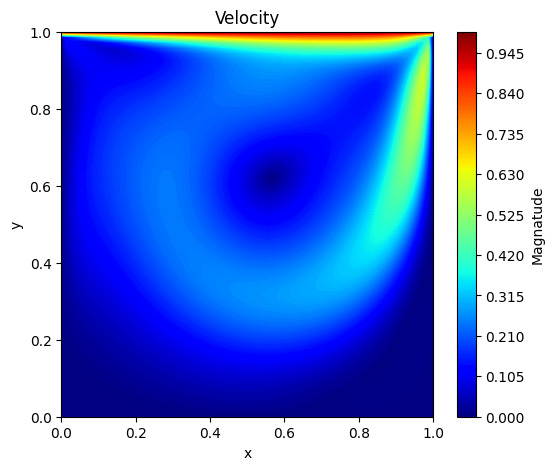

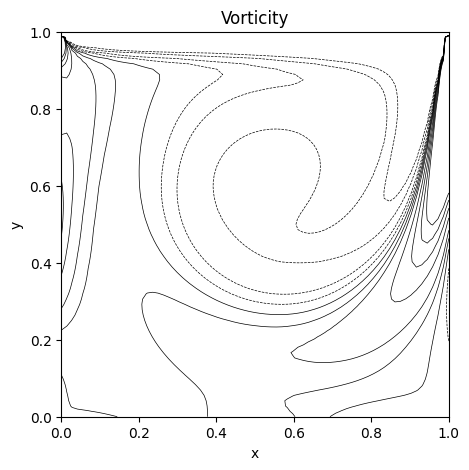

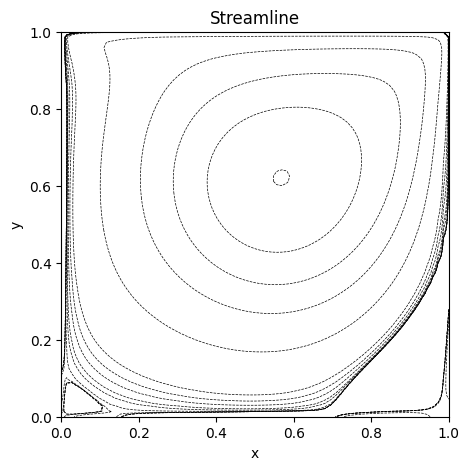

325
321
317
312
306
300
294
288
284
278


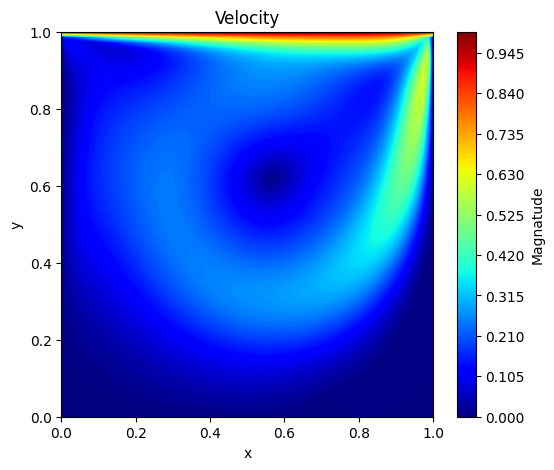

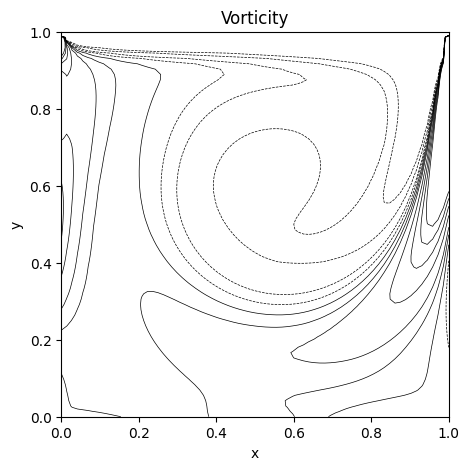

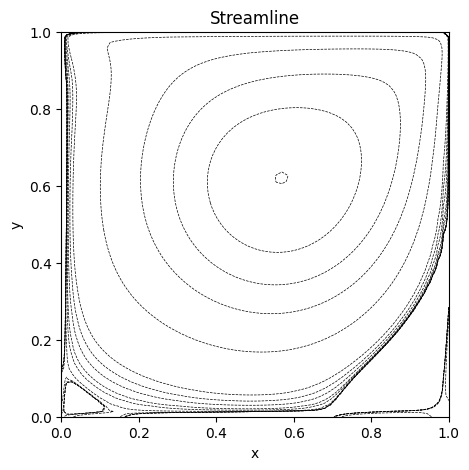

273
268
263
258
254
250
247
244
241
239


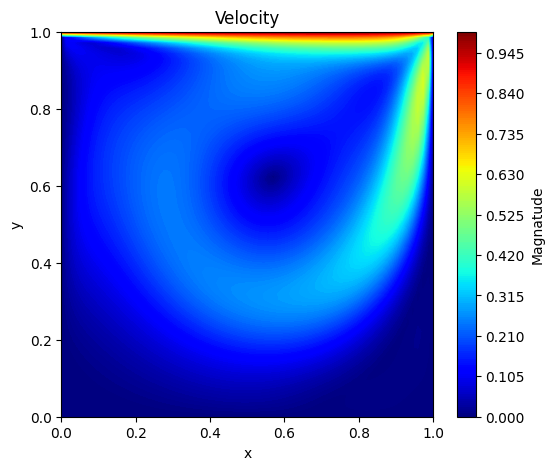

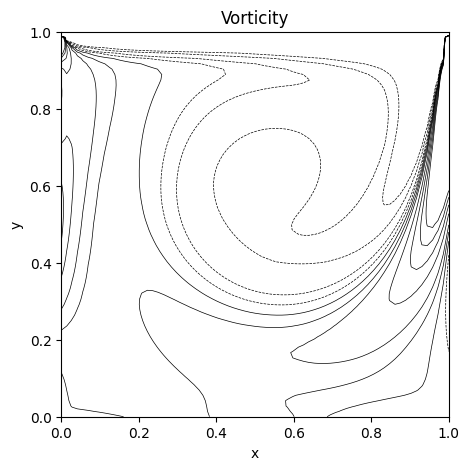

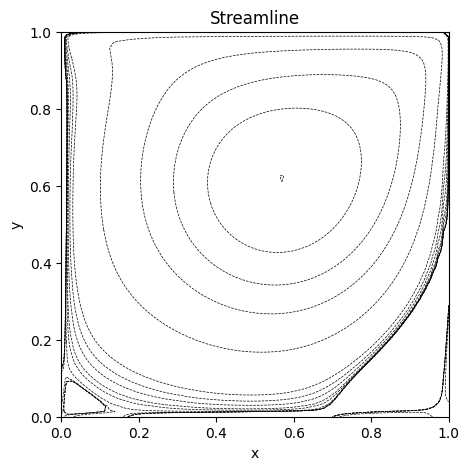

236
234
232
231
229
228
226
225
224
223


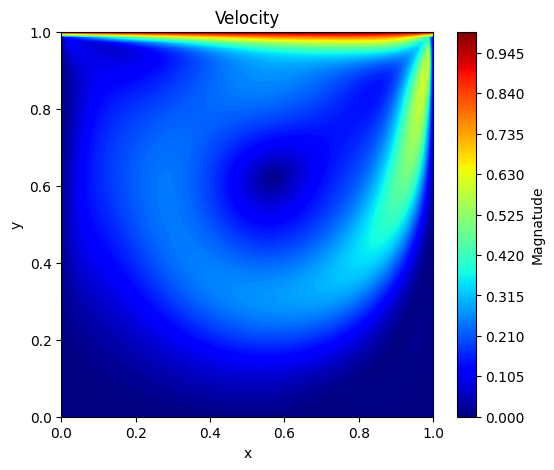

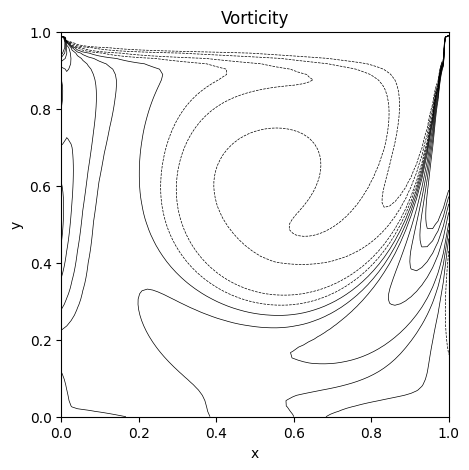

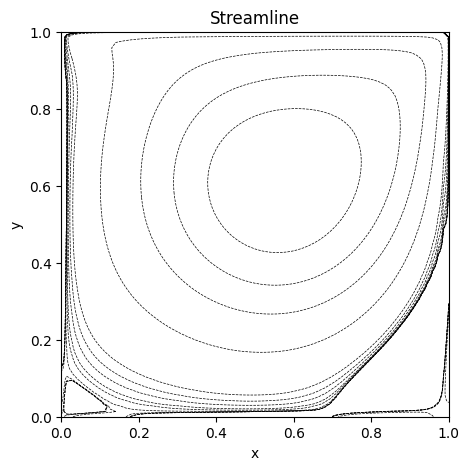

222
222
221
220
220
219
218
218
217
217


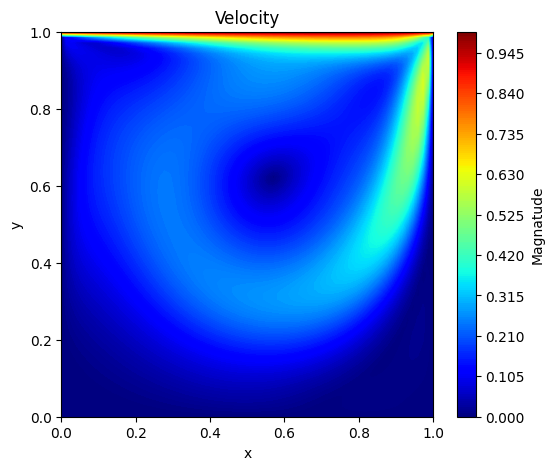

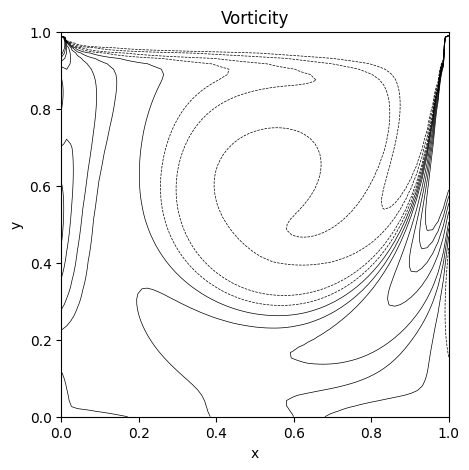

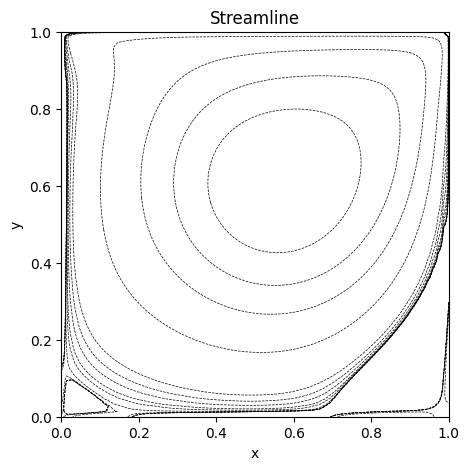

217
216
216
215
215
215
214
214
214
213


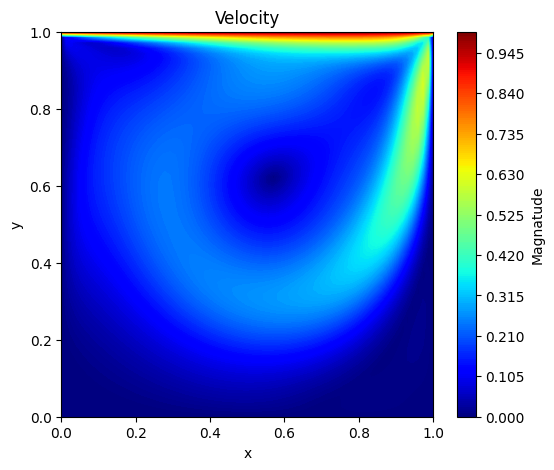

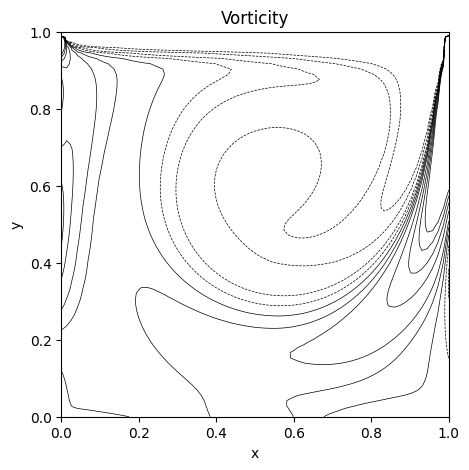

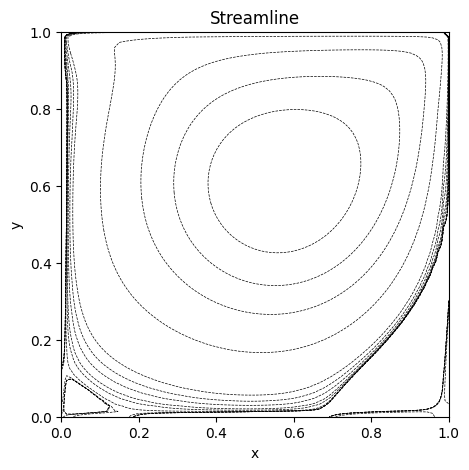

213
212
212
212
211
211
211
210


KeyboardInterrupt: 

In [249]:
while time < 40:
    ustar = u + dt * rhsU(u, v)
    vstar = v + dt * rhsV(u, v)
    setBc(ustar, vstar)

    p = SOR(ustar, vstar, p)
    u, v = proj_mtd(ustar, vstar, p)
    setBc(u, v)

    velo, vorti, psi = calculate(u, v)

    plot(velo, vorti, psi)

    time += dt
    step += 1

# Examples

## Save

In [240]:
#np.savez("C:/Users/user1/Desktop/CSE-URP/store100.npz", u100=u, v100=v, Re100u=u[24,:], Re100v=v[:,24])
#np.savez("C:/Users/user1/Desktop/CSE-URP/p100.npz", p100=p)
#np.savez("C:/Users/user1/Desktop/CSE-URP/store400.npz", u400=u, v400=v, Re400u=u[36,:], Re400v=v[:,36])
#np.savez("C:/Users/user1/Desktop/CSE-URP/p400.npz", p400=p)
np.savez("C:/Users/user1/Desktop/CSE-URP/store1000.npz", u1000=u, v1000=v, Re1000u=u[36,:], Re1000v=v[:,36])
np.savez("C:/Users/user1/Desktop/CSE-URP/p1000.npz", p1000=p)

## Load

In [238]:
load_file=np.load("C:/Users/user1/Desktop/CSE-URP/store1000.npz")
load_p=np.load("C:/Users/user1/Desktop/CSE-URP/p1000.npz")
load_file2=np.load("C:/Users/user1/Desktop/CSE-URP/store400.npz")
load_p2=np.load("C:/Users/user1/Desktop/CSE-URP/p400.npz")
load_file3=np.load("C:/Users/user1/Desktop/CSE-URP/store100.npz")
load_p3=np.load("C:/Users/user1/Desktop/CSE-URP/p100.npz")


u1000=load_file['u1000']
v1000=load_file['v1000']
Re1000u=load_file['Re1000u']
Re1000v=load_file['Re1000v']
p1000=load_file['p1000']

u400=load_file2['u400']
v400=load_file2['v400']
Re400u=load_file2['Re400u']
Re400v=load_file2['Re400v']
p400=load_p2['p400']

u100=load_file3['u100']
v100=load_file3['v100']
Re100u=load_file3['Re100u']
Re100v=load_file3['Re100v']
p100=load_p3['p100']

## Ghia Data

In [101]:
gy = [1, 0.9766, 0.9688, 0.9609, 0.9531, 0.8516, 0.7344, 0.6712, 0.5, 0.4531, 0.2813, 0.1719,\
      0.1016, 0.0703, 0.0625, 0.0547, 0]

gx = [1,0.9688,0.9609,0.9531,0.9453,0.9063,0.8594,0.8047,0.5,0.2344,0.2266,0.1563,0.0938,0.0781,\
      0.0703,0.0625,0]

gu100 = [1, 0.84123, 0.78871, 0.73722, 0.68717, 0.23151, 0.00332, -0.13641, -0.20581, -0.2109,\
     -0.15662, -0.1015, -0.06434, -0.04775, -0.04192, -0.03717, 0]

gu400 = [1,0.75837,0.68439,0.61756,0.55892,0.29093,0.16256,0.02135,-0.11477,-0.17119,-0.32726,\
        -0.24299,-0.14612,-0.10338,-0.09266,-0.08186,0]

gu1000 = [1,0.65928,0.57492,0.51117,0.46604,0.33304,0.18719,0.05702,-0.06080,-0.10648,-0.27805,\
          -0.38289,-0.29730,-0.22220,-0.20196,-0.18109,0]

gv100 = [0,-0.05906,-0.07391,-0.08864,-0.10313,-0.16914,-0.22445,-0.24533,0.05454,0.17527,0.17507,\
         0.16077,0.12317,0.10890,0.10091,0.09233,0]

gv400 = [0.00000,-0.12146,-0.15663,-0.19254,-0.22847,-0.23827,-0.44993,-0.38598,0.05186,0.30174,\
         0.30203,0.28124,0.22965,0.20920,0.19713,0.18360,0]

gv1000 = [0,-0.21388,-0.27669,-0.33714,-0.39188,-0.51550,-0.42665,-0.31966,0.02526,0.32235,0.33075,\
          0.37095,0.32627,0.30353,0.29012,0.27485,0]

In [183]:
x400u = [0, -0.003754702915387431, -0.028785953832060618, -0.0513141140323109, -0.07008758086585282, -0.08510635433268637, -0.10262821851594278, -0.11889859463306185, -0.13642045881631826, -0.1589486190165686, -0.18272838186710438, -0.2015018487006463, -0.2215269181844738, -0.23779717971744468, -0.25406755583456375, -0.26908632930139725, -0.28660819348465366, -0.30287856960177273, -0.31414264970189787, -0.32165203643531465, -0.32415512715173755, -0.325406729802023, -0.3166457404183207, -0.30413017225205824, -0.290362886851362, -0.2728410226681056, -0.24906125981756982, -0.2290363049178905, -0.2102628380843486, -0.19148937125080667, -0.17647059778397312, -0.15269083493343732, -0.1326657654496099, -0.11264081054993058, -0.0901126503496803, -0.06633288749914446, -0.03754694321576291, -0.01251557771494155, 0.02002505993514836, 0.052565697585238325, 0.07384236971935132, 0.10012522328631002, 0.12515647420298315, 0.14142685032010227, 0.16145180521978153, 0.1789737839871861, 0.19774725082072808, 0.22027541102097836, 0.23779727520423477, 0.2553191393874912, 0.2715895155046102, 0.292866073054575, 0.314142745188688, 0.33041300672165885, 0.35294116692190924, 0.3729662364057367, 0.40550687405582664, 0.43429293292335636, 0.45807258118974403, 0.48310394669056533, 0.5143929816903698, 0.5469337339246079, 0.5744680755577039, 0.6007509291246627, 0.6320401932927633, 0.655819841559151, 0.6858573884928181, 0.7133917301259143, 0.7459324823601523, 0.7809762107266651, 0.812265474894766, 0.8460577151951414, 0.8811014435616542, 0.9073842971286128, 0.934918638761709, 0.9612014923286676, 1]
y400u = [0, 0.00024379432624113478, 0.013482536153590427, 0.03050381274933511, 0.04279698581560284, 0.054144503546099294, 0.06549202127659574, 0.07967641843971632, 0.0929151602670656, 0.10804521276595745, 0.12695771345855497, 0.14019645528590427, 0.152489628352172, 0.1657283701795213, 0.17707588791001774, 0.1922059404089096, 0.20639033757203015, 0.22624849360039895, 0.24516099429299648, 0.2612367021276596, 0.28204042691710995, 0.2990617035128546, 0.3170286354443706, 0.3321586879432624, 0.35107118863585995, 0.3728205687610816, 0.39078750069259754, 0.4087544326241135, 0.4248300538840869, 0.4409056751440603, 0.45603572764295214, 0.47211134890292555, 0.48913262549867026, 0.5070995574301862, 0.5241208340259309, 0.5468158694869238, 0.5723477843805408, 0.5922059404089096, 0.6196291226867243, 0.6479979170129655, 0.6688016850897607, 0.6914967205507536, 0.7085179971464983, 0.7255392737422429, 0.7416149382895613, 0.7539080680684841, 0.7737662240968529, 0.7936243801252217, 0.8134825361535905, 0.8305038127493352, 0.8465794772966534, 0.8673832453734487, 0.8825132978723405, 0.8948064276512634, 0.9070995790738586, 0.9165558510638299, 0.9250664893617022, 0.9326314939674757, 0.937359619140625, 0.9420877659574469, 0.9487071368711215, 0.9534352836879433, 0.9572177751689939, 0.9610002882937169, 0.9628915340342421, 0.9657284134668662, 0.970456560283688, 0.9742390517647386, 0.9751846854568373, 0.9818040780141845, 0.9827496900626109, 0.9874778368794327, 0.9912603283604833, 0.9931515957446809, 0.9969340872257314, 0.9997709666583555, 1]

x100u = [0, -0.004835555942885206, -0.00938672418638048, -0.015075655844709435, -0.020764587503038556, -0.028729045991035262, -0.03669356177111194, -0.04465807755118867, -0.054898120160932984, -0.06172487252617581, -0.07082715172108633, -0.07651608337941529, -0.08561836257432592, -0.09585840518407035, -0.10154739413447927, -0.10951185262247604, -0.11747636840255271, -0.1322675792557923, -0.14364538528037052, -0.14933437423077955, -0.15502330588910856, -0.1618500009622716, -0.170952280157182, -0.17664121181551107, -0.18460572759558774, -0.1937080354365383, -0.1982591463879536, -0.207361454228904, -0.21418817794810674, -0.21760152548468836, -0.21532591271690077, -0.21532591271690077, -0.20849921764373774, -0.2039481066923226, -0.1891568958390829, -0.17664121181551107, -0.16071218025535772, -0.14933437423077955, -0.1368186902072076, -0.12088971593913422, -0.10154739413447927, -0.08448059915949202, -0.06627598347759117, -0.04693366167293622, -0.024177935039619958, -0.0025599718211375966, 0.028160213300175485, 0.06456938737189744, 0.0896006408348815, 0.10894301993161615, 0.12259646737002183, 0.1453521940033382, 0.17152126817323587, 0.1999659264648812, 0.23296175300002175, 0.25457960163434423, 0.2864376074625711, 0.3057800438513858, 0.33650017168061896, 0.36608270797125786, 0.40818069911714927, 0.47980793059634785, 0.5549018055694594, 0.6334090280791527, 0.6937117494911047, 0.7562898831485643, 0.8131793143160149, 0.8712063370220597, 0.9155799695817783, 1]
y100u = [0, 0.001064531212897875, 0.007082165163071089, 0.01825774633490829, 0.02857364077823659, 0.03888953522156457, 0.05092480312191099, 0.061240697565239297, 0.0792935994157591, 0.0921884674699189, 0.10680270898109749, 0.12055726376376685, 0.1343119051211319, 0.14720677317529202, 0.160101641229452, 0.17299659585830782, 0.1901897244056227, 0.2194182074279797, 0.24176936977165428, 0.2529450375181873, 0.2675591924546701, 0.28389280742286727, 0.3019456226986912, 0.3165598209225219, 0.33289343589071907, 0.35352526806472295, 0.36985883974557215, 0.3930696455304081, 0.42143844182425594, 0.4437896041679306, 0.4618425060184504, 0.48505331180328626, 0.5065448307057995, 0.5263170194386421, 0.5521068421216578, 0.5778966648046738, 0.5976688535375163, 0.6157217121006883, 0.6268972499851777, 0.6423711782248656, 0.6595643933468761, 0.6733189481295454, 0.6887928114382114, 0.7042667180342252, 0.7197406029865652, 0.7386531482782464, 0.7575656935699276, 0.779057169185093, 0.7936714106962715, 0.8048469702244347, 0.8134436210727879, 0.8220402069901194, 0.8340754532467919, 0.8443913909774678, 0.8564266372341404, 0.8650232339733087, 0.8710408462798082, 0.8770584802299815, 0.8822164490953193, 0.891672700097486, 0.9002693184803282, 0.9166028549902073, 0.9312170965013857, 0.9423926560295491, 0.9535682588450604, 0.9613052013212303, 0.9716211282300694, 0.9819370551389083, 0.9888143217084059, 1]

y1000u = [0, 0.009901012291436933, 0.01620162051804444, 0.023402362723140634, 0.029702970949748143, 0.03600364510091831, 0.04230425332752582, 0.047704793500207295, 0.05310533367288878, 0.06660668410459247, 0.07830783250388147, 0.09000904682773311, 0.09900992514068137, 0.11611161371265183, 0.12781282803650348, 0.1404140444897185, 0.15031505678115542, 0.1620162051804444, 0.17011701543946664, 0.18001802773090356, 0.1899190400223405, 0.20432045850797023, 0.21602160690725922, 0.22412241716628145, 0.3267326804472296, 0.3501350431703702, 0.37353733996894817, 0.4086408510913778, 0.4491449023864889, 0.5373536812572447, 0.6471647526678517, 0.7326732614522666, 0.7506751499272885, 0.768676906553185, 0.7911792012223996, 0.8118812279346368, 0.8343835226038514, 0.8532854132082366, 0.8658866296614516, 0.8739874399204738, 0.882088250179496, 0.892889330524859, 0.9081908170644147, 0.9207921653667551, 0.9324932478414815, 0.9441944621653331, 0.9504951363165033, 0.9567956786185481, 0.9621962187912295, 0.9666967568345477, 0.9720972970072291, 0.9756975692229333, 0.9792979732877627, 0.9810981093956147, 0.9846985134604441, 0.9864986495682962, 0.9882989175252735, 0.9918991897409777, 0.9927993237194664, 0.9954995938058071, 0.9963997277842959, 1]
x1000u = [0, -0.0504801859527807, -0.07352545460016474, -0.0927297982539323, -0.11385467473308675, -0.13305901838685436, -0.1522633620406219, -0.16762692135793034, -0.18491087284346835, -0.2175583836463148, -0.24252404446192838, -0.2713306302711584, -0.29437589891854243, -0.325102876896002, -0.3443072205497696, -0.359670779867078, -0.3692730220225404, -0.3731138063589996, -0.37695473135261603, -0.37695473135261603, -0.37119341419077, -0.365432097028924, -0.3519890705370024, -0.34238682838154, -0.22716048514461995, -0.20219482432900637, -0.17914955568162236, -0.14458165271054635, -0.10617282474585388, -0.017832675149934307, 0.09355274309336936, 0.18573381768290542, 0.20685869416205982, 0.22798357064121422, 0.25679015645044423, 0.28559674225967424, 0.3124827952435174, 0.3316872795544423, 0.3508916232082099, 0.36049386536367234, 0.36625518252551836, 0.37585728402382346, 0.3816186011856695, 0.3931412355093614, 0.4085047948266699, 0.4315500634740539, 0.4584362571150543, 0.49300416008613035, 0.5256516005603982, 0.564060358196512, 0.6063100408262422, 0.63895748130051, 0.685048018595278, 0.7234567762313918, 0.7676269213579302, 0.8175583133177361, 0.8559670709538499, 0.8886145817566963, 0.9212620222309641, 0.9635117048606944, 0.9999999999999999, 1]

x100v = [0, 0.0051883931858822604, 0.010451918687875175, 0.01721936270901462, 0.022482926074011533, 0.028498410835577692, 0.03451389559714393, 0.04128130175527934, 0.0488006671729881, 0.05481615193455426, 0.06459135726797877, 0.07286264408225678, 0.08188589015610807, 0.0924129790230978, 0.10369202714966094, 0.11271527322351224, 0.123242399953506, 0.13376948882049577, 0.1458004962066322, 0.1585833871263338, 0.16986243525289685, 0.1803895619828907, 0.1916685722464498, 0.2052033845627206, 0.2187382726049996, 0.2300172828685587, 0.2435521709108375, 0.25708705895311645, 0.2728776733220992, 0.28791647988352465, 0.30370709425250736, 0.3179938658283515, 0.33453643945690753, 0.3510790888114715, 0.36311005833460386, 0.38717199738086844, 0.4014587689567128, 0.3766448706508747, 0.41499365699899154, 0.42627266726255064, 0.4375517532521178, 0.4488307635156768, 0.46086173303880923, 0.47063690050922974, 0.4834198292919354, 0.49169115396921736, 0.5202646971209057, 0.5368073464754697, 0.5608692855217344, 0.5886909451398575, 0.6157606454984074, 0.6548613153800894, 0.6879465383632094, 0.7195278428271827, 0.7375742592488774, 0.7541169843294495, 0.7661478781265737, 0.7804346497024177, 0.7894578579132652, 0.799984984643259, 0.8120160298923992, 0.8225431566223931, 0.8338220911599442, 0.846605095668658, 0.8578841816582249, 0.8706670347149227, 0.8826980799640629, 0.8932250552420405, 0.9045041412316077, 0.9225505576533024, 0.9383412477482932, 0.9578915826891341, 0.9751861913032712, 0.9887211550715583, 1.0030077751953863]
y100v = [0, 0.009951514876047174, 0.02310108660437471, 0.03523912147152197, 0.0443426985552593, 0.05041171598883287, 0.059515293072570086, 0.07064184201191415, 0.08277992781243815, 0.0928949908239789, 0.10098703104653584, 0.11211363091925663, 0.12121715706961733, 0.12930917182548596, 0.13638975158692812, 0.14448176634279686, 0.15257385749873076, 0.15965436086010776, 0.16471191783256656, 0.1697694493383367, 0.17381546944961535, 0.17786146409420556, 0.1819075096721725, 0.18393050699446756, 0.18696501571125435, 0.18696501571125435, 0.18696501571125435, 0.1849420438556476, 0.1819075096721725, 0.17988451234987723, 0.17482695537741877, 0.17078096073282845, 0.16572340376036987, 0.16167740911577955, 0.15661985214332086, 0.14347030588168186, 0.13537821472574807, 0.1485278119207637, 0.12627466310869917, 0.11919415974732206, 0.11211363091925663, 0.10402153976332285, 0.09694103640194573, 0.08783745931820852, 0.077722396306668, 0.06963035608411083, 0.04333121262745587, 0.02613559532116161, -0.00016354813549335212, -0.03253175995909863, -0.06591145771050733, -0.11547523590703024, -0.15593543701981594, -0.19538420313817506, -0.2125797695110927, -0.2297754377507637, -0.23786742703994412, -0.24595946726250129, -0.25000551284046824, -0.2540516093518119, -0.2550630443462385, -0.2540516093518119, -0.25000551284046824, -0.24595946726250129, -0.23786742703994412, -0.22876390088958365, -0.2156143291612561, -0.20145322057174864, -0.18425770513220774, -0.15290092830302915, -0.12559029891857076, -0.09119906430598212, -0.05680788062677011, -0.028485714381131677, 0.0008479377923099607]

x400v = [0.0006767512174546311, 0.00744419523859411, 0.026242608782865915, 0.04278518241142187, 0.05481615193455426, 0.06383939800840552, 0.0773742481876804, 0.08940525557381677, 0.10519590780580347, 0.11873079584808237, 0.13527333161363436, 0.1510640217086251, 0.1661027904070465, 0.18114144551645597, 0.19918793766415857, 0.21422666849957595, 0.2300172828685587, 0.24881573427583442, 0.2653583836303985, 0.2819009572589544, 0.29769157162793713, 0.3157380637756397, 0.3330325966637689, 0.35408677439774855, 0.3736371093385897, 0.454846286140247, 0.5578615242094493, 0.639822584544672, 0.6631326400573714, 0.6804271729455007, 0.6939619852617716, 0.7150162387217592, 0.739078177768024, 0.7578765534492917, 0.7714114414915706, 0.7879540908461345, 0.8037447809411253, 0.8127679891519726, 0.8180314010649535, 0.8270547607278168, 0.8368299281982372, 0.8451011771495113, 0.8563802631390784, 0.8699150754553493, 0.8796902429257698, 0.8902173696557636, 0.8999925371261842, 0.9082637860774583, 0.9165351864807482, 0.9255583946915954, 0.9428528518537167, 0.9616513789870005, 0.9759381505628446, 0.990976881398262, 1.0037597344549598]
y400v = [0.001859474653490012, 0.036250658332702024, 0.09390652768515895, 0.1454933032039769, 0.1728039580551235, 0.18898806396692613, 0.21022967591781083, 0.22843677915190863, 0.24259786227472757, 0.2567589199308584, 0.2709200285203661, 0.2830581143208901, 0.29013864314895543, 0.29620768604921777, 0.3042997262717746, 0.30531123766626633, 0.3073342349885617, 0.30632274906075807, 0.3002537061604962, 0.29317317733243087, 0.2830581143208901, 0.26889703119807096, 0.2577704567920387, 0.236528844841154, 0.21528720742358098, 0.11717111149165016, -0.011290097074837302, -0.11547523590703024, -0.14582042494165215, -0.17009654560932352, -0.18729221384899453, -0.22067191160040323, -0.2601206267853856, -0.2935003245367942, -0.3208109539212525, -0.35317911481148107, -0.38251276698492276, -0.3946509037188234, -0.4057775035915442, -0.42095004717547846, -0.43207654518144567, -0.44320314505416647, -0.45028369934892015, -0.45028369934892015, -0.4442146819153465, -0.43005367519259247, -0.4169040015975114, -0.3976854124356104, -0.3744207776957424, -0.3359835993719401, -0.26517810735777925, -0.18324611733765084, -0.10738319568447308, -0.046692817615229476, 0.0008479377923099607]

x1000v = [0, 0.0017651819318444289, 0.0017651819318444289, 0.0052956750844757785, 0.010591350168951557, 0.015004369643033876, 0.021182700337903114, 0.025595719811985433, 0.031774050506854674, 0.03883490752317488, 0.04677842014988855, 0.055604588386995675, 0.06178285443739367, 0.06884377609818512, 0.07855247065674321, 0.08914382082569478, 0.09885258002872412, 0.11120917677399135, 0.12268311790886513, 0.13239187711189446, 0.14651365578900613, 0.15975284350019558, 0.172992031211385, 0.18534862795665225, 0.19770516005744823, 0.21270959434495337, 0.2259487820561428, 0.24448364485180804, 0.26654893615563335, 0.2947925581543279, 0.33451012128789626, 0.38481903459041616, 0.4748455110265044, 0.5631066762418058, 0.6381287830348601, 0.7069725591330452, 0.7502206154192449, 0.7678728226045166, 0.7819946659260996, 0.7969990355691334, 0.8102382232803229, 0.8208295734492744, 0.830538397296775, 0.8402470918553332, 0.8534862795665226, 0.8711384867517944, 0.8826124925311394, 0.8914386607682465, 0.8984995177845667, 0.9055603748008869, 0.9135038874276006, 0.9205648737328633, 0.9267430751387901, 0.9338040614440527, 0.9399822628499794, 0.9479257754766931, 0.9549867617819559, 0.9602824368664317, 0.9682259494931453, 0.976169462119859, 0.9841129747465727, 0.9796998259835478, 0.9876433386102614, 0.9920564873732863, 0.9955868512369751, 1]
y1000v = [0.011497693563668365, 0.027231489131651798, 0.04538580044540336, 0.06717097402190514, 0.09500756992897447, 0.1216339079631597, 0.14947050387022903, 0.16883511737891368, 0.1942511532181658, 0.21966714473536883, 0.24387292270173694, 0.2632374918883725, 0.28018154532924, 0.2959152522531252, 0.31164900349905955, 0.32738275474499395, 0.33827534153324484, 0.35279879058424607, 0.3612707729826307, 0.36853249750813133, 0.3745839641607479, 0.37700452422856506, 0.37700452422856506, 0.36974279970306445, 0.35885021291481356, 0.3467473239316295, 0.3334341770755614, 0.3080181412363093, 0.2838124075919903, 0.2499243450323044, 0.20272313561655045, 0.15068080606516215, 0.051437267098019934, -0.0429652403775862, -0.12284421015809288, -0.2015128334216174, -0.24992438935435357, -0.2692889585409891, -0.2862330119818566, -0.3068078390413762, -0.3237518924822437, -0.3394855994061289, -0.3600605151097467, -0.37821482642349824, -0.40968232891536693, -0.45688344968702266, -0.4810892276533908, -0.49924353896714235, -0.507715521365527, -0.5113463836282772, -0.5101361257553932, -0.49924353896714235, -0.48350983204325704, -0.45325258742427244, -0.4217851735765019, -0.3709531018979977, -0.3177004258296271, -0.27291982080373944, -0.2111951623369842, -0.15310136613297942, -0.09016644979334015, -0.11195162336984199, -0.059909205174355495, -0.027231444809602767, -0.0066566177500831936, 0]

x32 = [-0.003179630708014357, 0.0023847375862939596, 0.012718639274322529, 0.023052482741218655, 0.038155859601835034, 0.058823546535627234, 0.0834658737414193, 0.11764709307125447, 0.1319555185890179, 0.1510334192793692, 0.1756756882640287, 0.20111290859154116, 0.2138314896447312, 0.22496028445448032, 0.2400636030939642, 0.258346610662595, 0.2758346668883727, 0.28696346169812187, 0.30365662480217914, 0.31796505031994265, 0.33624799966744096, 0.35930048240865947, 0.37758348997729035, 0.3966613906676415, 0.44197140480722585, 0.5270270065709535, 0.5866454462283013, 0.6176470348501222, 0.6375198868833262, 0.6581875738171186, 0.6828299010229104, 0.7082670631292904, 0.7273449638196418, 0.7496025534391397, 0.7710651917157848, 0.7933227813352831, 0.8187599434416631, 0.8426073193046021, 0.8553259585789248, 0.8298886800302797, 0.8648649089241002, 0.871224170340129, 0.8799681693424517, 0.8910970223733334, 0.9022257589619499, 0.9085850203779787, 0.9165341844797132, 0.9213036596523011, 0.9292528237540356, 0.9356120851700644, 0.949920510687828, 0.9674086251347384, 0.9745628378936201, 0.9848966231393838, 0.9896660983119716, 0.9952305248274123, 0.998410213756559]
y32 = [0.0058900909379925315, 0.026047137437076928, 0.047120459077064525, 0.07460737116977911, 0.11034035689030808, 0.1451571010232936, 0.1781413955345511, 0.2074607572489936, 0.21845552208607932, 0.2285340453356216, 0.2404450517602511, 0.24960736697560915, 0.2523560581848806, 0.25327226621906485, 0.2560209574283362, 0.25510474939415206, 0.25143981659733705, 0.24777488380052182, 0.24319374296952256, 0.23586391092925185, 0.22395290450462224, 0.2056283076272658, 0.18913616037163683, 0.17356022115019232, 0.12774871218012107, 0.026047137437076928, -0.039921451585438195, -0.07473822927178303, -0.09947645015522627, -0.12513087907285364, -0.15994765675919848, -0.19384815930464017, -0.2268324538158977, -0.2607329563613394, -0.29005235162914134, -0.3248691293154862, -0.35235604140820087, -0.3688481215571108, -0.3679319135229266, -0.3615183230701995, -0.3651832223136552, -0.35968583989511216, -0.3514397662672977, -0.3376963102209405, -0.3193717468969433, -0.2964659420818685, -0.2753926875485999, -0.2506544666651568, -0.22591624578171357, -0.20301044096663873, -0.14803661678120938, -0.09672775894595481, -0.07107326292160854, -0.039921451585438195, -0.024345512363993682, -0.010602056317636277, 0.0013089165536337433]


## 2-(1)

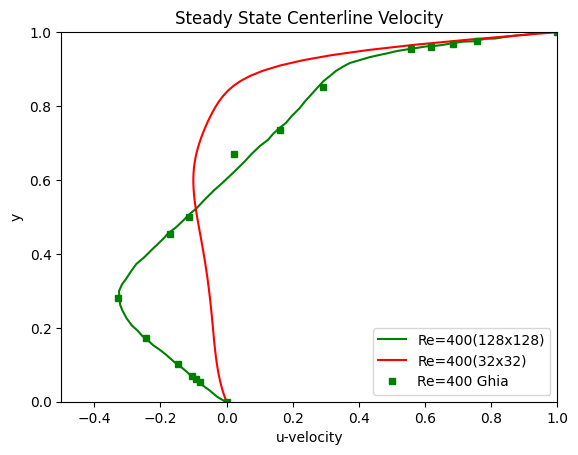

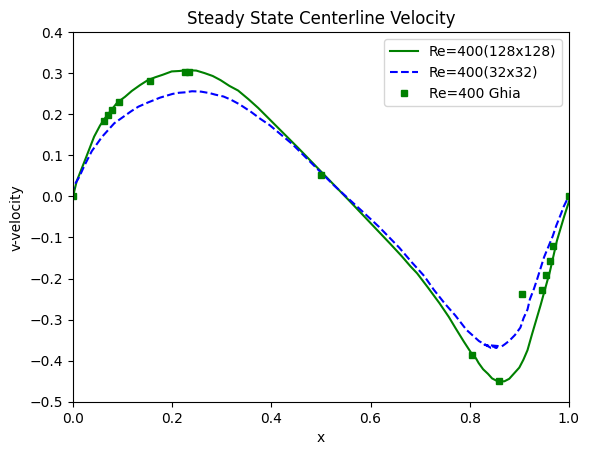

In [189]:
import numpy as np
import matplotlib.pyplot as plt

Nxt, Nyt = 48, 48
dxt, dyt = 1/Nxt, 1/Nyt

# Form Staggered grid
xt, yt = np.arange(0, 1+dxt, dxt), np.arange(0, 1+dyt, dyt)
xmt, ymt = xt - dxt/2, yt - dyt/2
xmt, ymt = np.append(xmt, 1 + dx/2), np.append(ymt, 1 + dyt/2)

plt.figure()
#plt.plot(x100u, y100u, 'b', label='Re=100')
#plt.plot(Re100u, ymt, 'b', label='Re=100')
plt.plot(x400u, y400u, 'g', label='Re=400(128x128)')
plt.plot(Re400u, ym, 'r', label='Re=400(32x32)')
#plt.plot(x1000u, y1000u,'r', label='Re=1000')
#plt.plot(gu100, gy, 'bs', label='Re=100 Ghia', markersize=5)
plt.plot(gu400, gy, 'gs', label='Re=400 Ghia', markersize=5)
#plt.plot(gu1000, gy, 'rs', label='Re=1000 Ghia', markersize=5)
plt.xlabel('u-velocity')
plt.ylabel('y')
plt.xlim([-0.5, 1])
plt.ylim([0, 1])
plt.title("Steady State Centerline Velocity")
plt.legend()
plt.show()

plt.figure()
#plt.plot(x100v, y100v, 'b', label='Re=100')
#plt.plot(xmt, Re100v, 'b', label='Re=100')
plt.plot(x400v, y400v, 'g', label='Re=400(128x128)')
plt.plot(x32, y32, 'b--', label='Re=400(32x32)')
#plt.plot(x1000v, y1000v, 'r', label='Re=1000')
#plt.plot(gx, gv100, 'bs', label='Re=100 Ghia', markersize=5)
plt.plot(gx, gv400, 'gs', label='Re=400 Ghia', markersize=5)
#plt.plot(gx, gv1000, 'rs', label='Re=1000 Ghia', markersize=5)
plt.xlabel('x')
plt.ylabel('v-velocity')
plt.xlim([0, 1])
plt.ylim([-0.5, 0.4])
plt.title("Steady State Centerline Velocity")
plt.legend()
plt.show()

## 3-(1)

In [63]:
np.savez("C:/Users/user1/Desktop/CSE-URP/dt0025.npz", u0025=u0025)

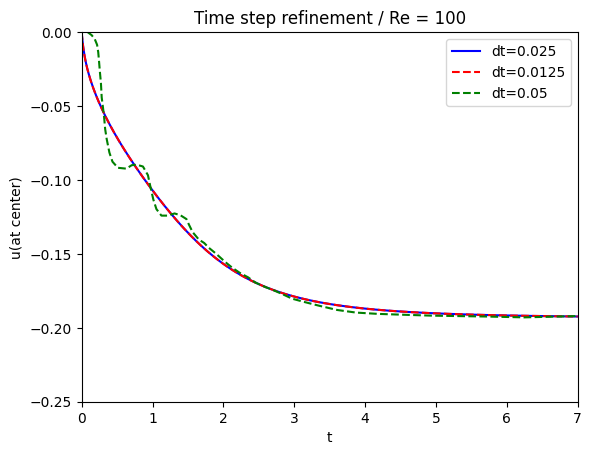

In [233]:
dt_size_file=np.load("C:/Users/user1/Desktop/CSE-URP/dt001.npz")
dt_size_file2=np.load("C:/Users/user1/Desktop/CSE-URP/dt00125.npz")
dt_size_file3=np.load("C:/Users/user1/Desktop/CSE-URP/dt0025.npz")

x88 = [0.07614601191867265, 0.14141407904391565, 0.18492625658230014, 0.21756029014492181, 0.23387730692623304, 0.24475525171966192, 0.2556331965130912, 0.27195021329440244, 0.2828283572701652, 0.2991453740514757, 0.3154623908327869, 0.33177940761409735, 0.3535352972009563, 0.39160840275145914, 0.4351203811075101, 0.5112665922085167, 0.6309245824832399, 0.7070707935842461, 0.7777777335150371, 0.8648016902271387, 0.9355090285225975, 0.9735819348907669, 1.0116548412589363, 1.0551670187973208, 1.125873958728112, 1.2128983138048808, 1.3108004144927459, 1.3923854983993, 1.4794094551114017, 1.5120434886740237, 1.5664338101881705, 1.6534577669002728, 1.729603978001279, 1.7948720451265223, 1.8927741458143867, 2.028749152870421, 2.1266512535582853, 2.2354314982219137, 2.3496506156910897, 2.4529915891845016, 2.588966596240536, 2.714063857685475, 2.839160720765746, 2.9696968550162324, 3.127428150023793, 3.3449882409863814, 3.606060509487353, 3.8725720491585416, 4.1825953680034464, 4.547008211633165, 4.933178139943744, 5.297590983573461, 5.694638657495137, 6.249417228059704, 6.994561525559122]
y88 = [0.0002941050767735349, -0.002058827090147825, -0.00470588587566226, -0.008529424208274584, -0.013529415160710379, -0.01941176442710588, -0.02588235615977775, -0.034411764211687686, -0.04411764642524062, -0.05029411692477429, -0.05676470865744618, -0.06558823794249428, -0.0723529401373946, -0.08147059065558092, -0.08764706115511457, -0.09176470456450048, -0.09235293625986708, -0.08999999870749083, -0.08970587747435264, -0.09088235163599563, -0.09676470090239114, -0.10529411972521086, -0.11323529608175414, -0.11970587704351623, -0.1241176416860403, -0.1241176416860403, -0.12264706783307862, -0.12382353122381189, -0.1264705900093263, -0.13000000172334555, -0.13529411929437443, -0.14029412640317487, -0.14264705318464135, -0.14588235443643216, -0.14970587661267984, -0.1555882366499851, -0.15941175882623276, -0.16294117054025203, -0.16588236132981443, -0.16941177304383367, -0.17235294229157655, -0.17470589061486255, -0.17735294940037702, -0.18029411864811984, -0.1823529349673579, -0.18499999375287232, -0.18794118454243475, -0.18970589039944435, -0.19058824332794916, -0.19117646425240603, -0.19176470671868243, -0.19205881718091083, -0.19235294918495882, -0.19294117010941564, -0.19205881718091083]

u001 = dt_size_file['u001']
u00125 = dt_size_file2['u00125']
u0025 = dt_size_file3['u0025']

t_list = np.linspace(0,7,np.size(u00125))
t2_list = np.linspace(0,7,np.size(u001))
t25_list = np.linspace(0,7,np.size(u0025))


plt.figure()
plt.plot(t2_list, u001, 'b', label='dt=0.025')
plt.plot(t_list, u00125, 'r--', label='dt=0.0125')
plt.plot(x88, y88, 'g--', label='dt=0.05')
plt.xlabel('t')
plt.ylabel('u(at center)')
plt.title("Time step refinement / Re = 100")
plt.xlim([0,7])
plt.ylim([-0.25,0])
plt.legend()
plt.show()

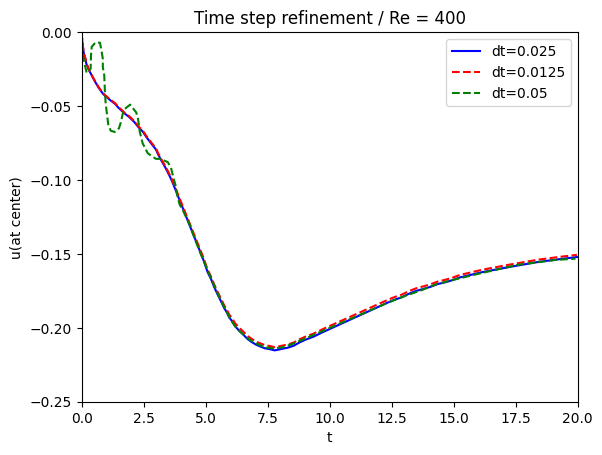

In [219]:
x55 = [0, 0.00894285445059704, 0.02894285445059704, 0.08683068324151905, 0.15918887931287584, 0.1881327937083371, 0.23154813532909688, 0.28943490417515516, 0.36179416019137517, 0.46309627065819325, 0.564399441069874, 0.6801729787619911, 0.8683068324151915, 0.9985528572774702, 1.1722142237605082, 1.3458755902435464, 1.4761216151058252, 1.736613664830383, 1.910275031313421, 2.11288031219192, 2.301013105900257, 2.460203045157997, 2.6049204972455744, 2.8509411197448333, 2.995658571832411, 3.0824892550739293, 3.212735279936208, 3.3719252191939475, 3.5311140985068237, 3.646888696143805, 4.891462175920532, 5.07959496962887, 5.209840994491148, 5.340087019353427, 5.499275898666304, 5.629521923528582, 5.745296521165561, 5.84659863163238, 5.947901802044061, 6.063675339736179, 6.179449937373158, 6.3531113038561955, 6.512301243113936, 6.685962609596975, 6.84515148890985, 7.033285342563051, 7.221418136271387, 7.395079502754426, 7.583212296462763, 7.785817577341261, 7.945007516599001, 8.176554591983233, 8.335745591185837, 8.56729266657007, 8.769899007393434, 9.015918569947827, 9.363241302913904, 9.696091548709816, 12.329957020295717, 12.604921557190435, 12.894356461365591, 13.19826385271091, 13.487698756886063, 13.791606148231383, 14.0665706851261, 14.370478076471418, 14.659912980646572, 14.934877517541294, 15.253257396056775, 15.600580129022848, 16.150507082922562, 17.27930596506231, 18.408104847202058, 19.29088416678741, 19.971057145549402]
y55 = [0,-0.0030319753642986573, -0.006890847594851018, -0.014332964814213254, -0.018467474380525612, -0.021499454791833003, -0.022877621282597953, -0.025633964358145363, -0.027839032762172786, -0.031146640415222672, -0.034178610732512556, -0.03748621838556245, -0.0418963652876348, -0.04382580644991972, -0.04630651218970715, -0.048511580593734574, -0.050992286333521965, -0.055126795899834324, -0.057331864303861745, -0.06063947195691164, -0.0644983542814815, -0.06725468726301141, -0.07083793225182128, -0.07635060830889857, -0.07938257862618849, -0.08269018627923835, -0.08682469584555072, -0.09151048008338306, -0.09674751880470038, -0.10088202837101272, -0.15325249633632587, -0.1623484173822131, -0.16675855419026794, -0.17227124034136276, -0.17805955373420002, -0.1824696905422549, -0.1866042001085672, -0.18936053309009715, -0.1929437881729245, -0.1954244939127119, -0.19873210156576177, -0.2020397092188117, -0.2045204149585991, -0.20755237518187145, -0.20948182643817395, -0.21141125750644135, -0.2127894139031888, -0.21389196324622875, -0.21444321772971373, -0.21527011964297618, -0.2147188651594912, -0.21389196324622875, -0.21334068857470878, -0.21196251198992633, -0.21003308092165893, -0.2081036498533915, -0.20589857135534653, -0.20314223837381665, -0.18302096521377487, -0.18109151395747244, -0.17943771013094745, -0.17695700439116005, -0.17502757332289262, -0.1736493967381102, -0.17227124034136276, -0.17034178908506034, -0.1692392599300553, -0.1678610833452729, -0.16593165227700546, -0.16455347569222298, -0.1623484173822131, -0.1587651622993857, -0.15545755464633584, -0.1535281235780684, -0.15214994699328593]
y66 = [0.99 * y55[i] for i in range(len(y55))]

x77 = [0,0.014471427225299014, 0.02894285445059704, 0.043415341620759766, 0.0578867688460578, 0.10130211046681806, 0.20260422093363611, 0.36179416019137517, 0.3762655874166742, 0.40520950181213494, 0.564399441069874, 0.7380608075529136, 0.7959475763989714, 0.8538343452450292, 0.8538343452450292, 0.9117221740359517, 0.9406650284865488, 0.9696089428820095, 1.0709110533488275, 1.1722142237605082, 1.331404163018249, 1.505065529501287, 1.5918962127428056, 1.6497829815888634, 1.707669750434922, 1.9536903729341812, 2.19971099543344, 2.2720691915047957, 2.301013105900257, 2.3444284475210164, 2.460203045157997, 2.662807266091632, 2.865412546970132, 2.995658571832411, 3.1693199383154487, 3.473227329660766, 3.6034733545230444, 3.690304037764563, 3.7771347210060826, 3.863965404247601, 3.950796087489121, 4.10998602674686, 4.3560055893012555, 4.573082297405054, 4.804631492679015, 5.2677277633372075, 5.615050496303284, 5.933429314873899, 6.020259998115417, 6.2373367062192155, 6.599131926355454, 6.830680061684551, 7.033285342563051, 7.250362050666849, 7.452966271600483, 7.713458321325041, 8.060781054291118, 8.422576274427357, 8.784369374673867, 12.344429507465879, 13.053545340678467, 13.675832610539267, 14.2836473932299, 15.05065105523341, 16.208394911713484, 17.597685843577786, 19.117222800304372, 19.91316931675848]
y77 = [0,-0.0035832399418011325, -0.007993386843873481, -0.011300994496923357, -0.017089307889760656, -0.02012127820705055, -0.027563395426412788, -0.02480706244488289, -0.015711141398995696, -0.00992283305316715, -0.006890847594851018, -0.007166484930611007, -0.01212789641018583, -0.018191847138783118, -0.023704523195860427, -0.029217199252937743, -0.04162072795187479, -0.048511580593734574, -0.06229327578343657, -0.06670342268550893, -0.06753032459877138, -0.06504961885898398, -0.06036384471516915, -0.055678060477336797, -0.05237045282428692, -0.049062845171237025, -0.05429989398657186, -0.05843440355288422, -0.06201764854169409, -0.06753032459877138, -0.07524806905987612, -0.0818632843659759, -0.08434399010576331, -0.08572216669054576, -0.08572216669054576, -0.08792723509457318, -0.09178610732512554, -0.09785005805372284, -0.10308710686905767, -0.11108049875993985, -0.11659316472299967, -0.1215545762025745, -0.1303748700067192, -0.14029769296586886, -0.1502205159250185, -0.16841235801679286, -0.1816427886289924, -0.19184123882988455, -0.19487321924119191, -0.20011025796250928, -0.20589857135534653, -0.2086549245249115, -0.2105843555931789, -0.21223815941970384, -0.21334068857470878, -0.21389196324622875, -0.21334068857470878, -0.21141125750644135, -0.20893055176665398, -0.18302096521377487, -0.17833518097594248, -0.17475194608115013, -0.17061743651483774, -0.16730982886178788, -0.16262404462395558, -0.15738700590263827, -0.15407939824958836, -0.15325249633632587]

plt.figure()
plt.plot(x55, y55, 'b', label='dt=0.025')
plt.plot(x55, y66, 'r--', label='dt=0.0125')
plt.plot(x77, y77, 'g--', label='dt=0.05')

plt.xlabel('t')
plt.ylabel('u(at center)')
plt.title("Time step refinement / Re = 400")
plt.xlim([0,20])
plt.ylim([-0.25,0])
plt.legend()
plt.show()